
## Downloading the data 

### AEM data

The "point of truth" source of the AEM data is under: https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/82307

```bash
mkdir -p $HOME/data/Lithology/AEM
cd $HOME/data/Lithology/AEM
wget https://d28rz98at9flks.cloudfront.net/82307/SwanCoastalPlain.zip
unzip SwanCoastalPlain.zip
# avoid spaces in folder names:
mv Swan\ Coastal\ Plain Swan_coastal_plains
```

Windows:

```bat
mkdir -p c:\data\Lithology\AEM
cd c:\data\Lithology\AEM
REM curl should come with anaconda3, perhaps not miniconda though
where curl
curl -o SwanCoastalPlain.zip https://d28rz98at9flks.cloudfront.net/82307/SwanCoastalPlain.zip
unzip SwanCoastalPlain.zip
REM avoid spaces in folder names:
mv "Swan Coastal Plain" Swan_coastal_plains
```

### Elevation

```bash
mkdir -p $HOME/data/Lithology/swan_coastal
cd $HOME/data/Lithology/swan_coastal
curl -o Swan_DEM.7z https://cloudstor.aarnet.edu.au/plus/s/HL3h7u67xUA1ilR/download
7za x Swan_DEM.7z
```

Windows:

```bat
mkdir -p c:\data\Lithology\swan_coastal
cd c:\data\Lithology\swan_coastal
curl -o Swan_DEM.7z https://cloudstor.aarnet.edu.au/plus/s/HL3h7u67xUA1ilR/download
7z x Swan_DEM.7z
```

### Borehole logs

```bash
mkdir -p $HOME/data/Lithology/
cd $HOME/data/Lithology/
curl -o NGIS_SCP.7z https://cloudstor.aarnet.edu.au/plus/s/KLEBWonjOAOPVVd/download
7za x NGIS_SCP.7z
```

Windows:

```bat
cd c:\data\Lithology
curl -o NGIS_SCP.7z https://cloudstor.aarnet.edu.au/plus/s/KLEBWonjOAOPVVd/download
7z x NGIS_SCP.7z
```



In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd


In [2]:
# Only set to True for co-dev of ela from this use case:
ela_from_source = False
ela_from_source = True

In [3]:
if ela_from_source:
    if ('ELA_SRC' in os.environ):
        root_src_dir = os.environ['ELA_SRC']
    elif sys.platform == 'win32':
        root_src_dir = r'C:\src\github_jm\pyela'
    else:
        username = os.environ['USER']
        root_src_dir = os.path.join('/home', username, 'src/ela/pyela')
    pkg_src_dir = root_src_dir
    sys.path.insert(0, pkg_src_dir)

from ela.textproc import *
from ela.utils import *
from ela.classification import *
from ela.visual import *
from ela.spatial import SliceOperation

## Importing data

There are two main sets of information we need: the borehole lithology logs, and the spatial information in the surface elevation (DEM) and geolocation of a subset of bores around Bungendore. 

In [4]:
data_path = None

You probably want to explicitly set `data_path` to the location where you put the folder(s) e.g:

In [5]:
#data_path = '/home/myusername/data' # On Linux, if you now have the folder /home/myusername/data/Bungendore
#data_path = r'C:\data\Lithology'  # windows, if you have C:\data\Lithology\Bungendore

Otherwise a fallback for the pyela developer(s)

In [6]:
if data_path is None:
    if ('ELA_DATA' in os.environ):
        data_path = os.environ['ELA_DATA']
    elif sys.platform == 'win32':
        data_path = r'C:\data\Lithology'
    else:
        username = os.environ['USER']
        data_path = os.path.join('/home', username, 'data')

In [7]:
data_path

'C:\\data\\Lithology'

In [8]:
aem_datadir = os.path.join(data_path, 'AEM')
swan_datadir = os.path.join(data_path, 'swan_coastal')
scp_datadir = os.path.join(aem_datadir, 'Swan_coastal_plains')
scp_grids_datadir = os.path.join(scp_datadir, 'grids')
ngis_datadir = os.path.join(data_path, 'NGIS')
scp_shp_datadir = os.path.join(data_path, 'NGIS/swan_coastal')

## DEM

Let's have a look at the DEM provided as part of the AEM package

In [9]:
dem = rasterio.open(os.path.join(scp_grids_datadir,'dem/Swan_Coastal_Plain_DEM_Final.ers'))

In [10]:
dem.crs

CRS.from_wkt('PROJCS["MGA50",GEOGCS["GEOCENTRIC DATUM of AUSTRALIA",DATUM["GDA94",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]')

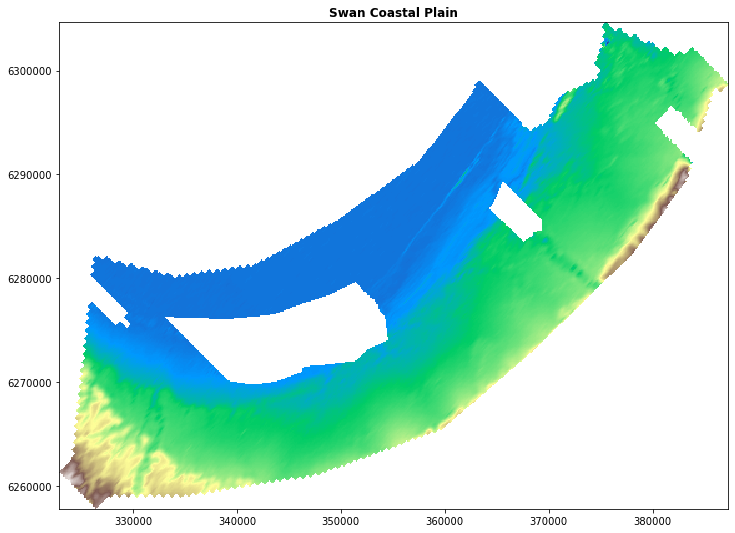

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
show(dem,title='Swan Coastal Plain', cmap='terrain',  ax=ax)

This is quite a gap in the data. Odd this should be this way. We will fortunately rely on the data from ELVIS which would not have these odd holes.

In [12]:
dem = rasterio.open(os.path.join(swan_datadir,'Swan_DEM/CLIP.tif'))

In [13]:
dem.crs

CRS.from_epsg(28350)

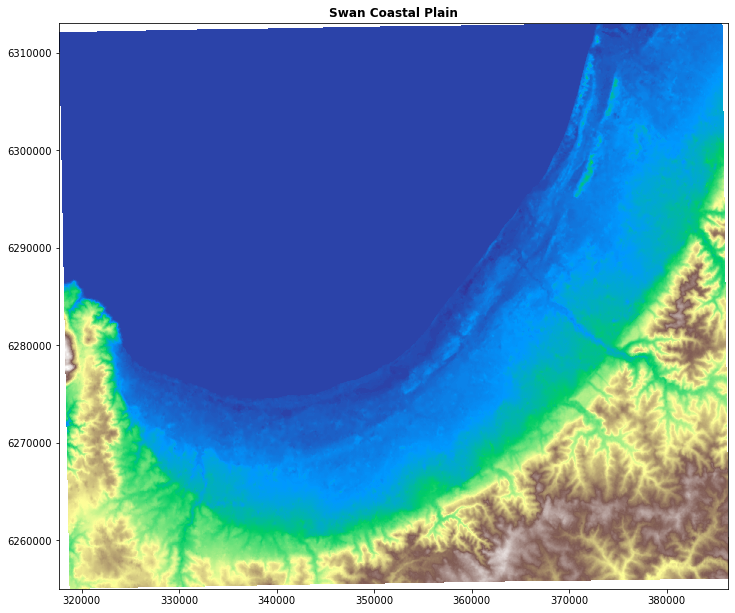

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
show(dem,title='Swan Coastal Plain', cmap='terrain',  ax=ax)

Now on to looking at the conductivity slices. 

## Conductivity slices

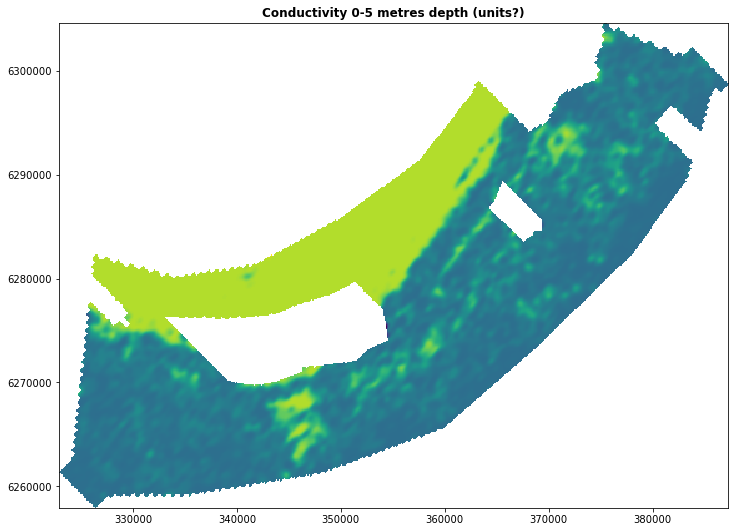

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
show(cnd_000_005,title='Conductivity 0-5 metres depth (units?)', cmap='viridis',  ax=ax)

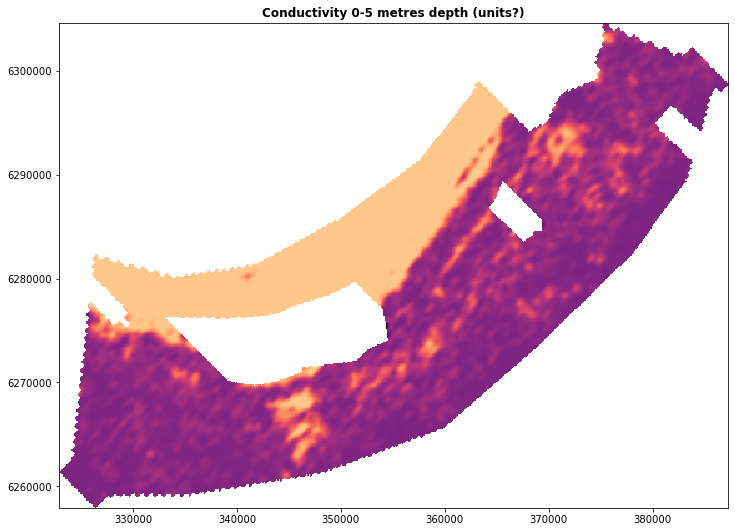

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
show(cnd_000_005,title='Conductivity 0-5 metres depth (units?)', cmap='magma',  ax=ax)

In [18]:
bore_locations_raw = gpd.read_file(os.path.join(scp_shp_datadir, 'scp.shp'))

In [19]:
bore_locations_raw.crs, dem.crs

({'init': 'epsg:3577'}, CRS.from_epsg(28350))

The DEM raster and the bore location shapefile do not use the same projection (coordinate reference system) so we reproject one of them. We choose the raster's UTM.

In [20]:
bore_locations = bore_locations_raw.to_crs(dem.crs)

In [21]:
wa_datadir = os.path.join(ngis_datadir, 'shp_WA')

In [22]:
lithology_logs_wa = pd.read_csv(os.path.join(wa_datadir, 'NGIS_LithologyLog.csv'))

In [23]:
len(lithology_logs_wa)

350963

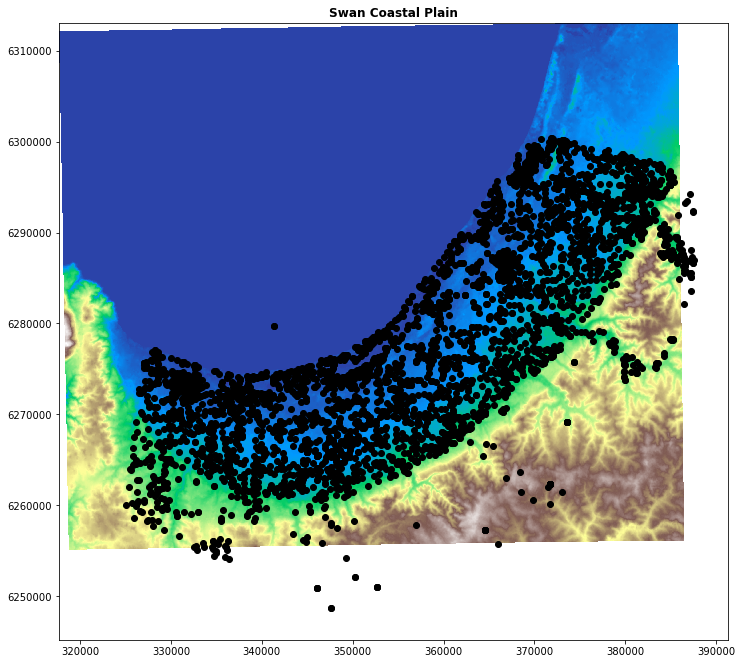

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))
show(dem,title='Swan Coastal Plain', cmap='terrain',  ax=ax)
bore_locations.plot(ax=ax, facecolor='black')

### Subset to the location of interest

The lithology logs are for all of western australia, which is much larger than the area of interest and for which we have the geolocation of boreholes. We subset to the location of interest 

In [25]:
df = lithology_logs_wa.copy()

Let's subset the logs based on spatial locations, to keep only those "nearby" the DEM we have near the locality of Bungendore in this case study. First define a few constants: 

In [26]:
df.columns

Index(['OBJECTID', 'BoreID', 'HydroCode', 'RefElev', 'RefElevDesc',
       'FromDepth', 'ToDepth', 'TopElev', 'BottomElev', 'MajorLithCode',
       'MinorLithCode', 'Description', 'Source', 'LogType'],
      dtype='object')

In [27]:
DEPTH_FROM_COL = 'FromDepth'
DEPTH_TO_COL = 'ToDepth'

TOP_ELEV_COL = 'TopElev'
BOTTOM_ELEV_COL = 'BottomElev'

LITHO_DESC_COL = 'Description'
HYDRO_CODE_COL = 'HydroCode'

### Merging the geolocation from the shapefile and lithology records

The geopandas data frame has a column geometry listing `POINT` objects. 'ela' includes  `get_coords_from_gpd_shape` to extrace the coordinates to a simpler structure. 'ela' has predefined column names (e.g. EASTING_COL) defined for easting/northing information, that we can use to name our coordinate information.

In [28]:
geoloc = get_coords_from_gpd_shape(bore_locations, colname='geometry', out_colnames=[EASTING_COL, NORTHING_COL])
geoloc[HYDRO_CODE_COL] = bore_locations[HYDRO_CODE_COL]
geoloc.head()

,Easting,Northing,HydroCode
0,362109.495805,6.286650e+06,61000444
1,373223.999880,6.299458e+06,61015408
2,337779.000007,6.272623e+06,61000925
3,327957.260220,6.276907e+06,61013498
4,341186.999944,6.273674e+06,61002806


With this data frame we can perform two operations in one go: subsetting the lithology records to only the 640 bores of interest, and adding to the result the x/y geolocations to the data frame.

In [29]:
len(geoloc), len(df)

(4416, 350963)

In [30]:
geoloc[HYDRO_CODE_COL].dtype, df[HYDRO_CODE_COL].dtype

(dtype('O'), dtype('int64'))

In [31]:
def parse_int(obj):
    try:
        return int(obj)
    except:
        return int(-9999)

In [32]:
parse_int('abc123'), parse_int('123')

(-9999, 123)

In [33]:
geoloc[HYDRO_CODE_COL] = geoloc[HYDRO_CODE_COL].apply(parse_int)

In [34]:
df = pd.merge(df, geoloc, how='inner', on=HYDRO_CODE_COL, sort=False, copy=True, indicator=False, validate=None)

In [35]:
len(df)

16943

In [36]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,Easting,Northing
0,1525789,50000329,61000850,None,UNK,0.0,3.0,None,None,None,None,SAND; grey-white; calcareous; moderately sorte...,UNK,1,350563.000078,6.277356e+06
1,1525790,50000329,61000850,None,UNK,3.0,6.0,None,None,None,None,SAND; Beige-grey; silty; calcareous; fine to m...,UNK,1,350563.000078,6.277356e+06
2,1525791,50000329,61000850,None,UNK,6.0,8.5,None,None,None,None,Sandy SILT; dark grey; fine rounded; subangula...,UNK,1,350563.000078,6.277356e+06
3,1525792,50000329,61000850,None,UNK,8.5,10.0,None,None,None,None,Sandy CLAY; green to fine medium calcareous sa...,UNK,1,350563.000078,6.277356e+06
4,1525793,50000329,61000850,None,UNK,10.0,12.0,None,None,None,None,Gravelly CLAY; sandy; orange-green; stiff; coa...,UNK,1,350563.000078,6.277356e+06


### Round up 'depth to' and 'depth from' columns

We round the depth related columns to the upper integer value and drop the entries where the resulting depths have degenerated to 0. `ela` has a class `DepthsRounding` to facilitate this operations on lithology records with varying column names.

We first clean up height/depths columns to make sure they are numeric.

In [37]:
def as_numeric(x):
    if isinstance(x, float):
        return x
    if x == 'None':
        return np.nan
    elif x is None:
        return np.nan
    elif isinstance(x, str):
        return float(x)
    else:
        return float(x)

In [38]:
df[DEPTH_FROM_COL] = df[DEPTH_FROM_COL].apply(as_numeric)
df[DEPTH_TO_COL] = df[DEPTH_TO_COL].apply(as_numeric)
df[TOP_ELEV_COL] = df[TOP_ELEV_COL].apply(as_numeric)
df[BOTTOM_ELEV_COL] = df[BOTTOM_ELEV_COL].apply(as_numeric)

In [39]:
dr = DepthsRounding(DEPTH_FROM_COL, DEPTH_TO_COL)

In [40]:
"Before rounding heights we have " + str(len(df)) + " records"

'Before rounding heights we have 16943 records'

In [41]:
df = dr.round_to_metre_depths(df, np.round, True)
"After removing thin sliced entries of less than a metre, we are left with " + str(len(df)) + " records left"

'After removing thin sliced entries of less than a metre, we are left with 15059 records left'

## Exploring the descriptive lithology 

In [42]:
descs = df[LITHO_DESC_COL]
descs = descs.reset_index()
descs = descs[LITHO_DESC_COL]
descs.head()

0    SAND; grey-white; calcareous; moderately sorte...
1    SAND; Beige-grey; silty; calcareous; fine to m...
2    Sandy SILT; dark grey; fine rounded; subangula...
3    Sandy CLAY; green to fine medium calcareous sa...
4    Gravelly CLAY; sandy; orange-green; stiff; coa...
Name: Description, dtype: object

The description column as read seems to be objects. Other columns seem to be objects when they should be numeric. We define two functions to clean these.

In [43]:
def clean_desc(x):
    if isinstance(x, float):
        return u''
    elif x is None:
        return u''
    else:
        # python2 return unicode(x)        
        return x

In [44]:
y = [clean_desc(x) for x in descs]

In [45]:
from striplog import Lexicon
lex = Lexicon.default()

In [46]:
y = clean_lithology_descriptions(y, lex)

We get a flat list of all the "tokens" but remove stop words ('s', 'the' and the like)

In [47]:
y = v_lower(y)
vt = v_word_tokenize(y)
flat = np.concatenate(vt)

In [48]:
import nltk
from nltk.corpus import stopwords

In [49]:
stoplist = stopwords.words('english')
exclude = stoplist + ['.',',',';',':','(',')','-']
flat = [word for word in flat if word not in exclude]

In [50]:
len(set(flat))

3514

In [51]:
df_most_common= token_freq(flat, 50)

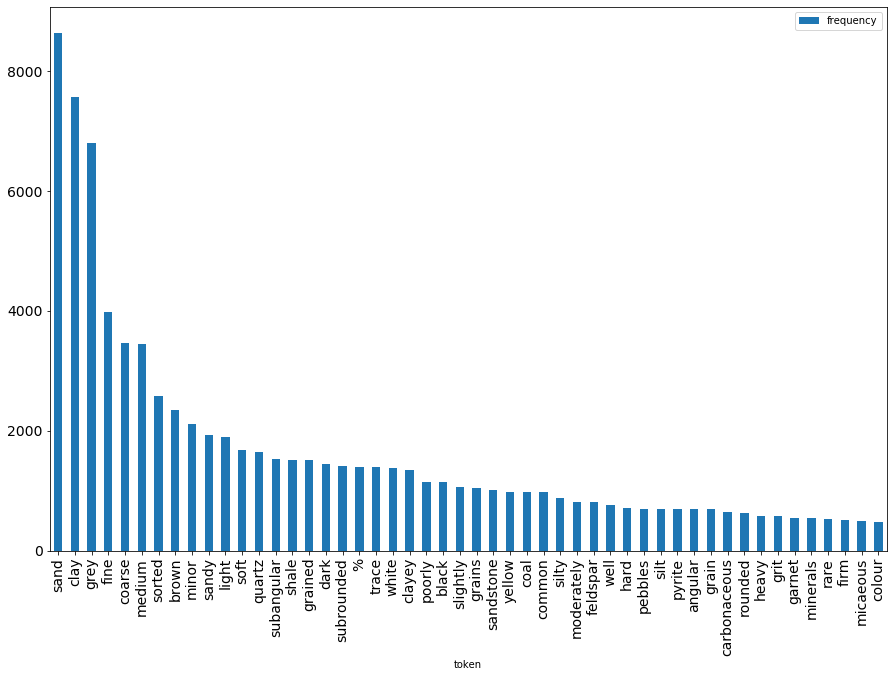

In [52]:
plot_freq(df_most_common)

There are terms such as 'sandy', 'clayey', 'silty' and so on. Let's define functions to detect terms derived from lithology classes, and their frequency. Given the likely skewness, we use a y log scale. 

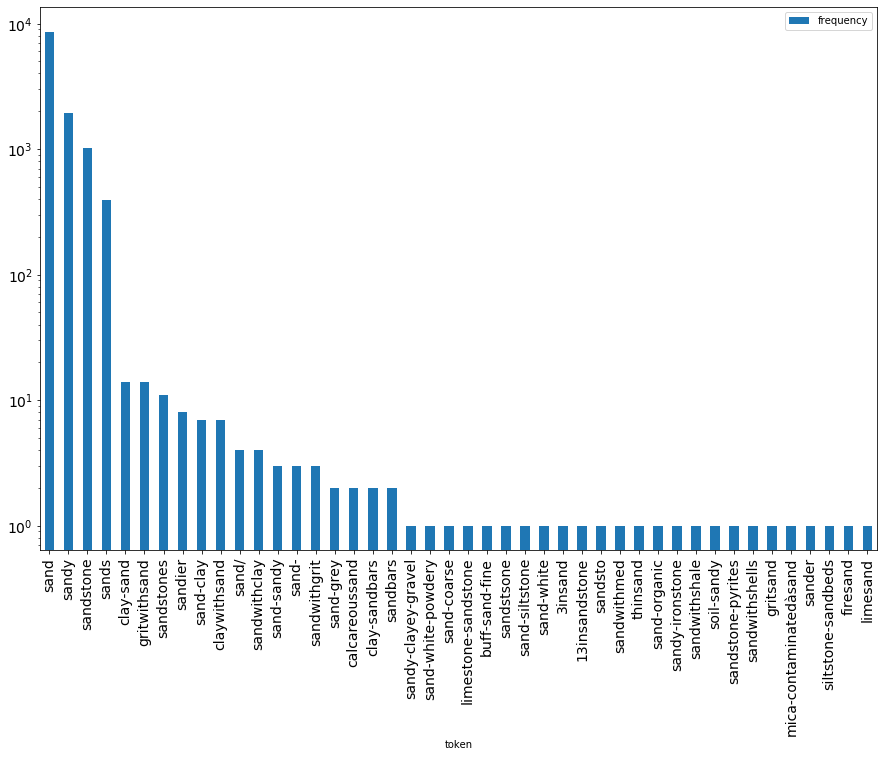

In [53]:
plot_freq_for_root(flat, 'sand')

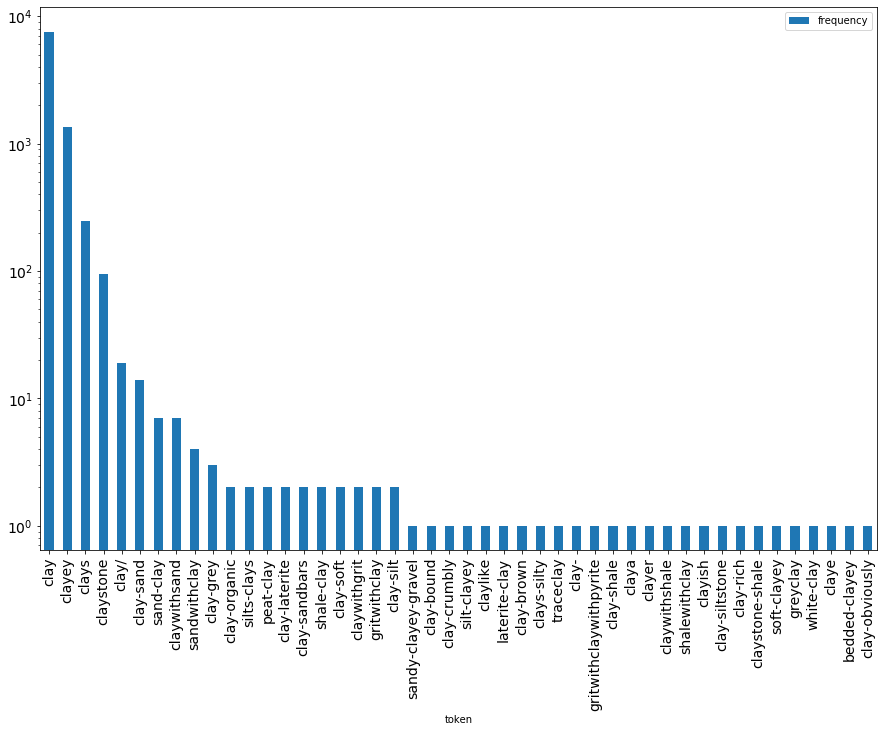

In [54]:
plot_freq_for_root(flat, 'clay')

In [55]:
# TODO: add a section that defines additional clean up e.g. 'sand/clay/soil' or dashed union composite terms
# split_composite_term('sand/clay/soil', '/').replace('/', ' / ')

In [56]:
df_most_common

,token,frequency
0,sand,8635
1,clay,7576
2,grey,6808
3,fine,3983
4,coarse,3464
5,medium,3450
6,sorted,2590
7,brown,2341
8,minor,2120
9,sandy,1936


## Defining lithology classes and finding primary/secondary lithologies

From the list of most common tokens, we may want to define lithology classes as follows:

In [57]:
df[LITHO_DESC_COL] = y

In [58]:
lithologies = ['sand', 'clay','quartz','shale','sandstone', 'coal','pebbles','silt','pyrite','grit','limestone']

And to capture any of these we devise a regular expression:

In [59]:
any_litho_markers_re = r'sand|clay|quart|ston|shale|silt|pebb|coal|pyr|grit|lime'
regex = re.compile(any_litho_markers_re)

In [60]:
my_lithologies_numclasses = create_numeric_classes(lithologies)

In [61]:
lithologies_dict = dict([(x,x) for x in lithologies])
lithologies_dict['sands'] = 'sand'
lithologies_dict['clays'] = 'clay'
lithologies_dict['shales'] = 'shale'
lithologies_dict['claystone'] = 'clay'
lithologies_dict['siltstone'] = 'silt'
lithologies_dict['limesand'] = 'sand' # ??
lithologies_dict['calcarenite'] = 'limestone' # ??
lithologies_dict['calcitareous'] = 'limestone' # ??
lithologies_dict['mudstone'] = 'silt' # ??
lithologies_dict['capstone'] = 'limestone' # ??
lithologies_dict['ironstone'] = 'sandstone' # ??
#lithologies_dict['topsoil'] = 'soil' # ??

In [62]:
lithologies_adjective_dict = {
    'sandy' :  'sand',
    'clayey' :  'clay',
    'clayish' :  'clay',
    'shaley' :  'shale',
    'silty' :  'silt',
    'pebbly' :  'pebble',
    'gravelly' :  'gravel'
}

In [63]:
v_tokens = v_word_tokenize(y)
litho_terms_detected = v_find_litho_markers(v_tokens, regex=regex)

Let's see if we detect these lithology markers in each bore log entries  

In [64]:
zero_mark = [x for x in litho_terms_detected if len(x) == 0 ]
at_least_one_mark = [x for x in litho_terms_detected if len(x) >= 1]
at_least_two_mark = [x for x in litho_terms_detected if len(x) >= 2]
print('There are %s entries with no marker, %s entries with at least one, %s with at least two'%(len(zero_mark),len(at_least_one_mark),len(at_least_two_mark)))

There are 999 entries with no marker, 14060 entries with at least one, 8418 with at least two


Note: probably need to think of precanned facilities in ela to assess the detection rate in such EDA. Maybe wordcloud not such a bad idea too.

In [65]:
descs_zero_mark = [y[i] for i in range(len(litho_terms_detected)) if len(litho_terms_detected[i]) == 0 ]

In [66]:
descs_zero_mark[1:20]

['gravel',
 'conglomerates',
 'conglomerates',
 'basalt',
 'basalt',
 'basalt',
 'basalt',
 'basalt',
 'basalt',
 'soft with water',
 'soft with water',
 'basalt',
 'basalt',
 'basalt',
 'basalt',
 'large water shed',
 'large water shed',
 'top soil',
 'water bearing']

In [67]:
primary_litho = v_find_primary_lithology(litho_terms_detected, lithologies_dict)

In [68]:
secondary_litho = v_find_secondary_lithology(litho_terms_detected, primary_litho, lithologies_adjective_dict, lithologies_dict)

In [69]:
df[PRIMARY_LITHO_COL]=primary_litho
df[SECONDARY_LITHO_COL]=secondary_litho

In [70]:
df[PRIMARY_LITHO_NUM_COL] = v_to_litho_class_num(primary_litho, my_lithologies_numclasses)
df[SECONDARY_LITHO_NUM_COL] = v_to_litho_class_num(secondary_litho, my_lithologies_numclasses)

In [71]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,Easting,Northing,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num
0,1525789,50000329,61000850,None,UNK,0.0,3.0,NaN,NaN,None,None,sand; grey-white; calcareous; moderately sorte...,UNK,1,350563.000078,6.277356e+06,sand,clay,0.0,1.0
1,1525790,50000329,61000850,None,UNK,3.0,6.0,NaN,NaN,None,None,sand; beige-grey; silty; calcareous; fine to m...,UNK,1,350563.000078,6.277356e+06,sand,silt,0.0,7.0
2,1525791,50000329,61000850,None,UNK,6.0,8.0,NaN,NaN,None,None,sandy silt; dark grey; fine rounded; subangula...,UNK,1,350563.000078,6.277356e+06,silt,sand,7.0,0.0
3,1525792,50000329,61000850,None,UNK,8.0,10.0,NaN,NaN,None,None,sandy clay; green to fine medium calcareous sa...,UNK,1,350563.000078,6.277356e+06,clay,sand,1.0,0.0
4,1525793,50000329,61000850,None,UNK,10.0,12.0,NaN,NaN,None,None,gravelly clay; sandy; orange-green; stiff; coa...,UNK,1,350563.000078,6.277356e+06,clay,sand,1.0,0.0


## Converting depth below ground to Australian Height Datum elevation

While the bore entries have columns for AHD elevations, many appear to be missing data. Since we have a DEM of the region we can correct this.

In [72]:
cd = HeightDatumConverter(dem)

In [73]:
df = cd.add_height(df, 
        depth_from_col=DEPTH_FROM_COL, depth_to_col=DEPTH_TO_COL, 
        depth_from_ahd_col=DEPTH_FROM_AHD_COL, depth_to_ahd_col=DEPTH_TO_AHD_COL, 
        easting_col=EASTING_COL, northing_col=NORTHING_COL, drop_na=False)

In [74]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,Source,LogType,Easting,Northing,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num,Depth From (AHD),Depth To (AHD)
0,1525789,50000329,61000850,None,UNK,0.0,3.0,NaN,NaN,None,...,UNK,1,350563.000078,6.277356e+06,sand,clay,0.0,1.0,5.435274,2.435274
1,1525790,50000329,61000850,None,UNK,3.0,6.0,NaN,NaN,None,...,UNK,1,350563.000078,6.277356e+06,sand,silt,0.0,7.0,2.435274,-0.564726
2,1525791,50000329,61000850,None,UNK,6.0,8.0,NaN,NaN,None,...,UNK,1,350563.000078,6.277356e+06,silt,sand,7.0,0.0,-0.564726,-2.564726
3,1525792,50000329,61000850,None,UNK,8.0,10.0,NaN,NaN,None,...,UNK,1,350563.000078,6.277356e+06,clay,sand,1.0,0.0,-2.564726,-4.564726
4,1525793,50000329,61000850,None,UNK,10.0,12.0,NaN,NaN,None,...,UNK,1,350563.000078,6.277356e+06,clay,sand,1.0,0.0,-4.564726,-6.564726


In [75]:
# to be reused in experimental notebooks:
classified_logs_filename = os.path.join(swan_datadir,'classified_logs.pkl')
df.to_pickle(classified_logs_filename)


## Interpolate over a regular grid


In [76]:
# max/min bounds
shp_bbox = get_bbox(bore_locations)
shp_bbox

(325021.2646776653, 6248696.545707192, 387522.9999722309, 6300389.151156738)

In [77]:
raster_bbox = dem.bounds
raster_bbox

BoundingBox(left=317660.7954, bottom=6255037.223, right=386336.7677, top=6313102.7631)

In [78]:
x_min = max(shp_bbox[0], raster_bbox[0])
x_max = min(shp_bbox[2], raster_bbox[2])
y_min = max(shp_bbox[1], raster_bbox[1])
y_max = min(shp_bbox[3], raster_bbox[3])


In [79]:
grid_res = 200
m = create_meshgrid_cartesian(x_min, x_max, y_min, y_max, grid_res)

In [80]:
[x.shape for x in m]

[(307, 227), (307, 227)]

In [81]:
dem_array = surface_array(dem, x_min, y_min, x_max, y_max, grid_res)

In [82]:
dem_array.shape

(307, 227)

In [83]:
dem_array[dem_array <= 0.0] = np.nan

C:\Users\daice\Anaconda3\envs\ELA\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


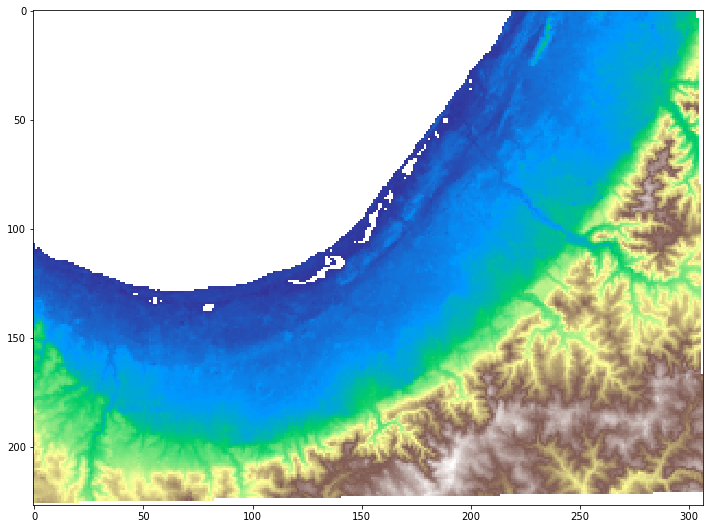

In [84]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(to_carto(dem_array), cmap='terrain')

In [85]:
dem_array_data = {'bounds': (x_min, x_max, y_min, y_max), 'grid_res': grid_res, 'mesh_xy': m, 'dem_array': dem_array}

In [86]:
import pickle

fp = os.path.join(swan_datadir, 'dem_array_data.pkl')
if not os.path.exists(fp):
    with open(fp, 'wb') as handle:
        pickle.dump(dem_array_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

We need to define min and max heights on the Z axis for which we interoplate. We use the KNN algorithm with 10 neighbours. We should use a domain such that there are enough points for each height. Let's find visually heights with at least 10 records

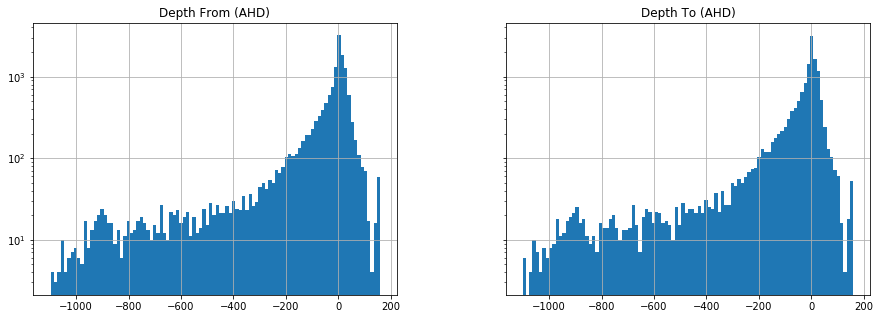

In [87]:
n_bins=100
p = df.hist(column=[DEPTH_FROM_AHD_COL,DEPTH_TO_AHD_COL], sharex=True, sharey=True, bins=n_bins, figsize=(15,5))
for axes in p:
    axes[0].set_yscale("log", nonposy='clip')

In [88]:
n_neighbours=10
ahd_min=-180
ahd_max=50

z_ahd_coords = np.arange(ahd_min,ahd_max,1)
dim_x,dim_y = m[0].shape
dim_z = len(z_ahd_coords)
dims = (dim_x,dim_y,dim_z)

In [89]:
dims

(307, 227, 230)

In [90]:
lithology_3d_array=np.empty(dims)

In [91]:
gi = GridInterpolation(easting_col=EASTING_COL, northing_col=NORTHING_COL)

In [92]:
gi.interpolate_volume(lithology_3d_array, df, PRIMARY_LITHO_NUM_COL, z_ahd_coords, n_neighbours, m)

In [93]:
# Burn DEM into grid
z_index_for_ahd = z_index_for_ahd_functor(b=-ahd_min)

In [94]:
dem_array.shape, m[0].shape, lithology_3d_array.shape

((307, 227), (307, 227), (307, 227, 230))

In [95]:
burn_volume(lithology_3d_array, dem_array, z_index_for_ahd, below=False)

In [96]:
# to be reused in experimental notebooks:
interp_litho_filename = os.path.join(swan_datadir,'3d_primary_litho.pkl')
with open(interp_litho_filename, 'wb') as handle:
    pickle.dump(lithology_3d_array, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 2D visualisations

In [97]:
lithology_color_names = ['yellow', 'olive', 'lightgrey', 'dimgray', 'teal',  'cornsilk',     'saddlebrown', 'rosybrown', 'chocolate', 'lightslategrey', 'gold']

In [98]:
lithology_cmap = discrete_classes_colormap(lithology_color_names) # Later for exporting to RGB geotiffs??
litho_legend_display_info = [(lithology_cmap[i], lithologies[i], lithology_color_names[i]) for i in range(len(lithologies))]

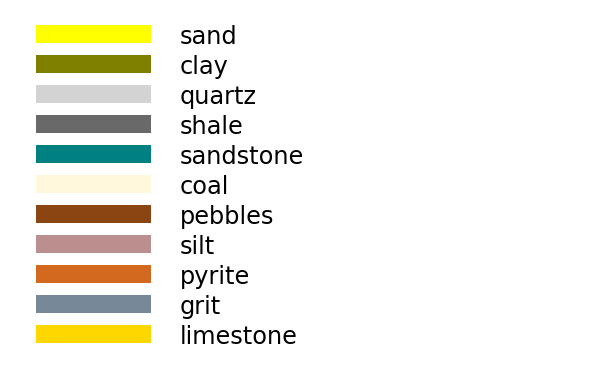

In [99]:
litho_legend = legend_fig(litho_legend_display_info)

In [100]:
cms = cartopy_color_settings(lithology_color_names)

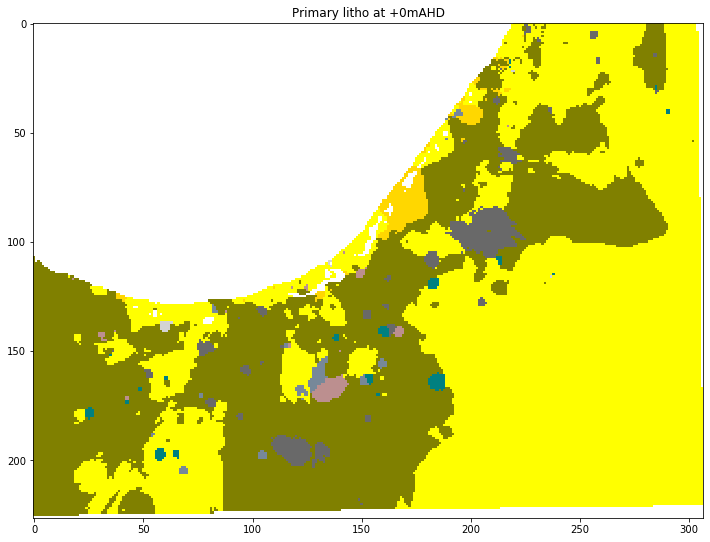

In [101]:
fig, ax = plt.subplots(figsize=(12, 12))
imgplot = plt.imshow(to_carto(lithology_3d_array[:, :, z_index_for_ahd(0)]), cmap=cms['cmap'])
title = plt.title('Primary litho at +0mAHD')

## 3D visualisation

In [102]:
from ela.visual3d import *

In [103]:
xx, yy = dem_array_data['mesh_xy']

In [104]:
from mayavi import mlab

In [105]:
vis_litho = LithologiesClassesVisual3d(lithologies, lithology_color_names, 'black')

In [106]:
# TODO: problematic with this data - investigate
# vis_litho.render_classes_planar(lithology_3d_array, 'Primary lithology')

In [107]:
# vis_litho.render_class(lithology_3d_array, 0)

ela has facilities to visualise overlaid information: DEM, classified bore logs, and volumes of interpolated lithologies. This is important to convey .

First a bit of data filling for visual purposes, as NaN lithology class codes may cause issues.

In [108]:
df_infilled = df.fillna({PRIMARY_LITHO_NUM_COL: -1.0})
df_infilled = df_infilled[(df_infilled[DEPTH_TO_AHD_COL] > (ahd_min-20))]

In [109]:
# A factor to apply to Z coordinates, otherwise things would be squashed visually along the heights.
# Would prefer a visual only scaling factor, but could not find a way to do so. 
Z_SCALING = 20.0

In [110]:
z_coords = np.arange(ahd_min,ahd_max,1)

In [111]:
overlay_vis_litho = LithologiesClassesOverlayVisual3d(lithologies, lithology_color_names, 'black', dem_array_data, z_coords, Z_SCALING, df_infilled, PRIMARY_LITHO_NUM_COL)

In [112]:
def view_class(value):
    f = overlay_vis_litho.view_overlay(value, lithology_3d_array)
    return f

In [113]:
f = view_class(1.0)

In [114]:
f = view_class(1.0)

In [ ]:
f = view_class(2.0)

![3D Interpolated overlay primary lithology quartz](img/snapshot_quartz.png)

In [ ]:
vis_litho = LithologiesClassesVisual3d(lithologies, lithology_color_names, 'black')

In [ ]:
vis_litho.render_classes_planar(lithology_3d_array, 'Primary lithology')